# Linear Regression

### Importing Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Loading the dataset

In [4]:
data = pd.read_csv('../dataset/spotify_features.csv', sep=',')
data.head()

,track_popularity,instrumentalness,duration_ms,energy,acousticness,album_month,album_year,danceability,loudness,liveness,genre_code,valence,artist_code
0,67.0,0.004210,162600.0,0.815,0.0724,12,2019,0.726,-4.969,0.35700,2,0.693000,4535
1,70.0,0.000023,176616.0,0.931,0.0794,7,2019,0.675,-3.432,0.19031,2,0.613000,7724
2,60.0,0.000009,169093.0,0.930,0.0287,7,2019,0.718,-3.778,0.20400,2,0.509838,6862
3,62.0,0.000000,187675.0,0.856,0.1870,7,2019,0.449,-4.788,0.17600,2,0.152000,3635
4,58.0,0.000005,207894.0,0.923,0.1460,6,2019,0.679,-6.500,0.12400,2,0.752000,2056


### Data Preprocessing

In [5]:
X = data.drop(columns=['track_popularity'])
y = data['track_popularity']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25)

print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (11908, 12), (11908,)
Validation set: (3970, 12), (3970,)
Test set: (3970, 12), (3970,)


### Standardization

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Model Training

In [7]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

### Model Evaluation

In [8]:
train_score = model.score(X_train_scaled, y_train)
val_score = model.score(X_val_scaled, y_val)
test_score = model.score(X_test_scaled, y_test)

print(f"Train R^2: {train_score:.2f}")
print(f"Validation R^2: {val_score:.2f}")
print(f"Test R^2: {test_score:.2f}")

Train R^2: 0.07
Validation R^2: 0.06
Test R^2: 0.08


### Cross-validation #1

In [9]:
scores = cross_validate(model, X, y, cv=6, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.006020,0.001500,-0.019134,0.073994
1,0.005016,0.001509,0.003976,0.079029
2,0.006010,0.001510,-0.256902,0.100582
3,0.006005,0.001514,0.014968,0.060991
4,0.007065,0.001507,-0.016322,0.079318
5,0.004996,0.001514,-0.112533,0.054374


### Hyperparamter Tuning

#### Ridge & Lasso

In [10]:
# Pipeline with standard scaling and ridge or lasso regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())  # Start with Ridge, can change to Lasso for comparison
])

# Hyperparameters for Ridge and Lasso
ridge_params = {
    'regressor': [Ridge()],
    'regressor__alpha': [0.1, 1.0, 10, 50, 100]
}

lasso_params = {
    'regressor': [Lasso()],
    'regressor__alpha': [0.01, 0.1, 1.0, 10, 50]
}

# Combine both parameter sets for GridSearch
param_grid = [ridge_params, lasso_params]

# GridSearchCV setup with 5-fold cross-validation
gridsearch = GridSearchCV(pipeline, param_grid, cv=8, scoring='r2', n_jobs=-1) # n_jobs is how much cores can it use
gridsearch.fit(X_train, y_train)

# Best estimator and its scores
print(f"Best parameters: {gridsearch.best_params_}")
best_model = gridsearch.best_estimator_

# Evaluate best model on training, validation, and test sets
train_score = best_model.score(X_train, y_train)
val_score = best_model.score(X_val, y_val)
test_score = best_model.score(X_test, y_test)

print(f"Best Model Train R^2: {train_score:.2f}")
print(f"Best Model Validation R^2: {val_score:.2f}")
print(f"Best Model Test R^2: {test_score:.2f}")

# this may suggest that the relationship between features and target is non-linear

Best parameters: {'regressor': Ridge(), 'regressor__alpha': 100}
Best Model Train R^2: 0.07
Best Model Validation R^2: 0.06
Best Model Test R^2: 0.08


### Cross-validation #2

In [11]:
scores = cross_validate(model, X, y, cv=6, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.006013,0.002003,-0.019134,0.073994
1,0.006517,0.002501,0.003976,0.079029
2,0.008584,0.000999,-0.256902,0.100582
3,0.005013,0.001504,0.014968,0.060991
4,0.005020,0.001502,-0.016322,0.079318
5,0.005014,0.001002,-0.112533,0.054374


### Visualizations

#### Feature Importance

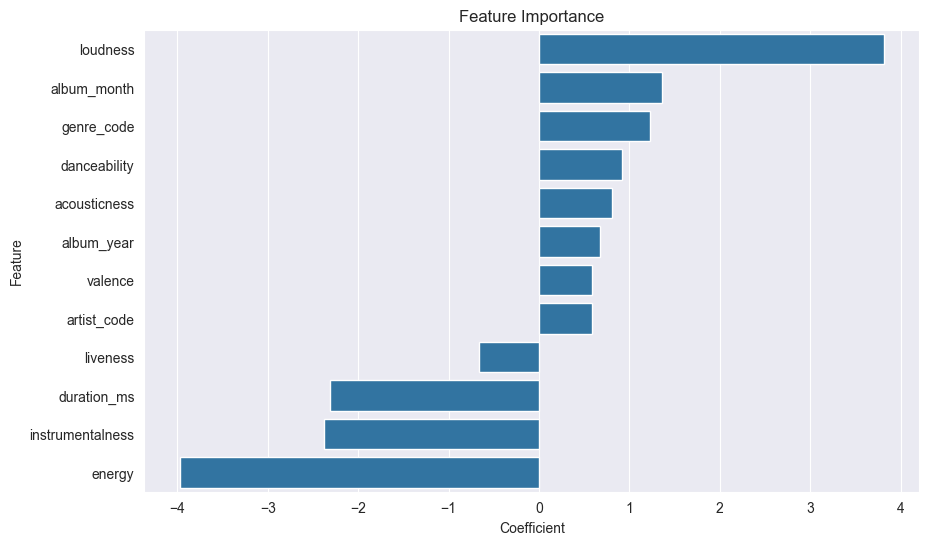

In [12]:
coefficients = model.coef_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
importance_df = importance_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

#### Actual vs Predicted

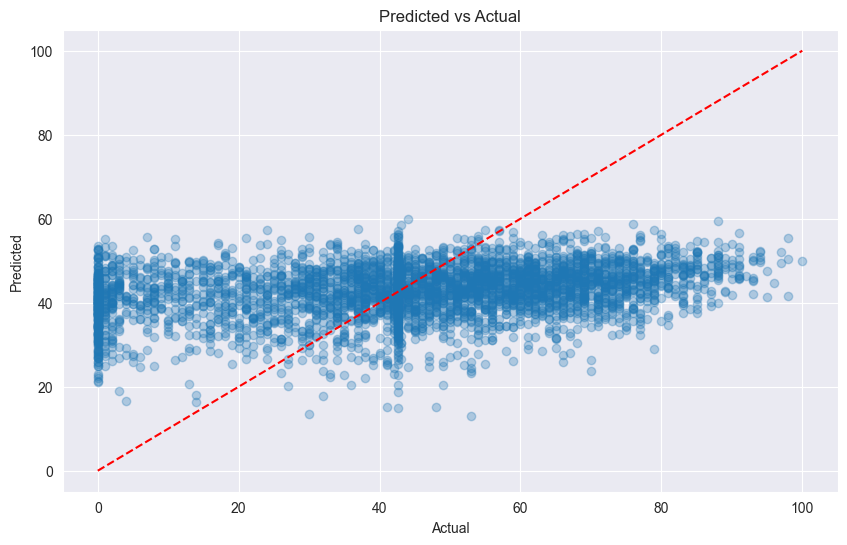

In [13]:
y_pred = model.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

#### Residuals

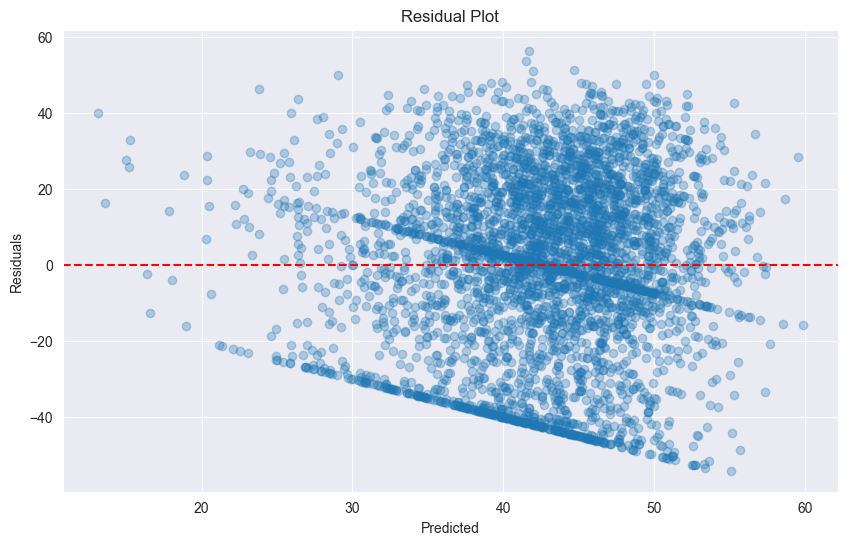

In [14]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()